# Cycle sale analysis

This is a notebook preceeding after SQL script and Tableau analysis. The main focus on this notebook is to perform statistical analysis, to determine if a relation between predoctors exists statistically.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import scipy

In [2]:
#| output: false
!pip install optuna

Let's have a look at the dataframe we will be working with:

In [3]:
sales_df = pd.read_csv('./sales_cleaned.csv', index_col='index')
sales_df.head()

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,net_profit,Day,Month_numeric
index,,,,,,,,,,,,,,,,,
0,02/19/16,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,1.0,80.00,109.000000,80.0,109.0,29,19,2
1,02/20/16,2016,February,29,F,United States,Washington,Clothing,Gloves,2.0,24.50,28.500000,49.0,57.0,8,20,2
2,02/27/16,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,3.0,3.67,5.000000,11.0,15.0,4,27,2
3,03/12/16,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,2.0,87.50,116.500000,175.0,233.0,58,12,3
4,03/12/16,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,3.0,35.00,41.666667,105.0,125.0,20,12,3


In [4]:
print(f"The dataframe has {sales_df.shape[0]} rows and {sales_df.shape[1]} features")

(34866, 17)

From the dataframe, we can see that the interesting columns are categorical features:
* Countries/States
* Product categories/sub-categories
* Customer's gender

and the numberic features:
* Cost
* Revenue
* Profit
* Customer's age

ALthough datetime features are also included in the dataframe, we will be ignoring these since the time-series analysis was analysed in our [Tableau](https://public.tableau.com/views/bikesalesanalysis_16728519380800/Distributionsofunitpricesacrossproductcategories_?:language=en-GB&:display_count=n&:origin=viz_share_link) and SQL analysis.

In [ ]:
sales_df.info()

In [5]:
sales_df.describe()

,Year,Customer Age,Quantity,Unit Cost,Unit Price,Cost,Revenue,net_profit,Day,Month_numeric
count,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000
mean,2015.569237,36.382895,2.002524,349.880567,389.232485,576.004532,640.870074,64.865542,15.667671,6.317845
std,0.495190,11.112902,0.813936,490.015846,525.319091,690.500395,736.650597,152.879908,8.770677,3.465317
min,2015.000000,17.000000,1.000000,0.670000,0.666667,2.000000,2.000000,-937.000000,1.000000,1.000000
25%,2015.000000,28.000000,1.000000,45.000000,53.666667,85.000000,102.000000,5.000000,8.000000,3.000000
50%,2016.000000,35.000000,2.000000,150.000000,179.000000,261.000000,319.000000,27.000000,16.000000,6.000000
75%,2016.000000,44.000000,3.000000,455.000000,521.000000,769.000000,902.000000,96.000000,23.000000,9.000000
max,2016.000000,87.000000,3.000000,3240.000000,5082.000000,3600.000000,5082.000000,1842.000000,31.000000,12.000000


It appears that most of the distribution are a long tailed distribution, skewed to the lower end.

In [6]:
sales_df.duplicated().mean()

2.868123673492801e-05

In [7]:
sales_df[sales_df.duplicated(keep=False)].sort_values(['Date', 'Revenue'])

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,net_profit,Day,Month_numeric
index,,,,,,,,,,,,,,,,,
868,08/12/15,2015,August,43,F,Germany,Bayern,Accessories,Bottles and Cages,2.0,10.0,14.0,20.0,28.0,8,12,8
869,08/12/15,2015,August,43,F,Germany,Bayern,Accessories,Bottles and Cages,2.0,10.0,14.0,20.0,28.0,8,12,8


Out of 34866 entries, there was one entry that appears to be duplicated. It is quite possible that one person with the same demographic information purchased the exact same item on the same day. We will leave the duplicated entry as it is only one of them.

# Statistical tests

First, let's investigate the claim of gender having no relation with revenue generated

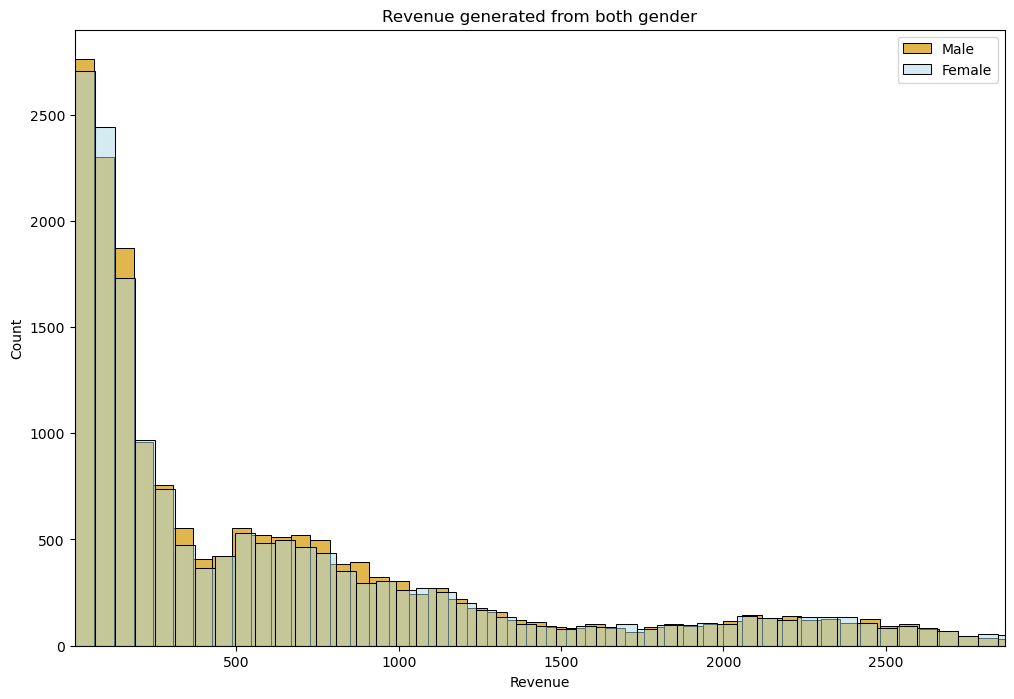

In [8]:
plt.figure(figsize = (12, 8))
sns.histplot(sales_df[sales_df['Customer Gender'] == 'M'].Revenue, 
                color='goldenrod', alpha = 0.8, label = 'Male')
sns.histplot(sales_df[sales_df['Customer Gender'] == 'F'].Revenue, 
                color='lightblue', alpha = 0.5, label = 'Female')
plt.xlim((sales_df['Revenue'].min(), sales_df['Revenue'].quantile(0.99)))
plt.title('Revenue generated from both gender')
plt.legend()
plt.show()

From the figure above, we can see that the two distributions from each gender are almost identical.

However, it apperas that the distributions consist of 3 difference distribution, with a right skewed, long tail distribution (likely to be from product sales with low pricing),
and 2 gaussian mixture distributions (centered at 600 and 2200)

In [9]:
sales_df['Product Category'].unique()

array(['Accessories', 'Clothing', 'Bikes'], dtype=object)

Coincidently, it apperas that we have exactly 3 different product categories. Let's investigate if these 3 product correspond to the 3 distributions we see.

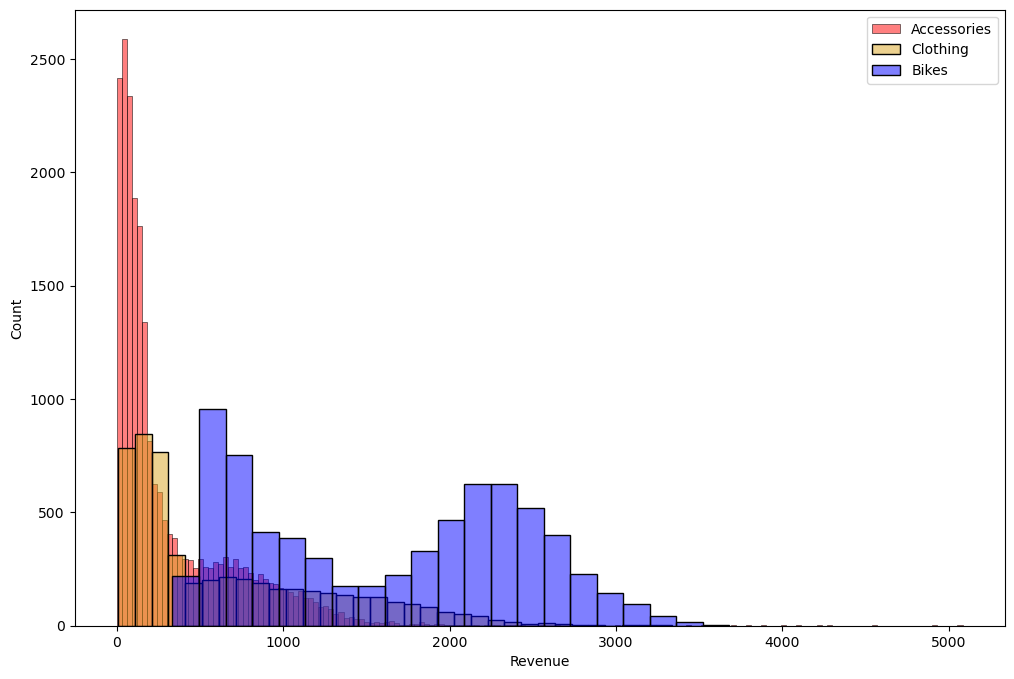

In [10]:
plt.figure(figsize=(12, 8))
for prod, color in zip(sales_df['Product Category'].unique(), ['red', 'goldenrod', 'blue']):
    sns.histplot(sales_df[sales_df['Product Category'] == prod]['Revenue'], 
    label = prod, color=color, alpha = 0.5)
plt.legend()
plt.show()

It appers that our guess was wrong, both accessories and cloting made up the right-skewed distribution, whereas the gaussian mixture distributin was from bikes category alone.

## T-test on revenues generated for different gender.

To determine if different gender had different spending habits, we will be running a unpaired t-test to investigate if the two distribution is the same.

The hypothesis of a unpaired t-test is as follows:
$$H_0: \bar{X} - \bar{Y} = 0$$
$$H_1: \bar{X} - \bar{Y} \neq 0$$

where X and Y are the two distribution compared.

In [11]:
ttest_stat, ttest_p = scipy.stats.ttest_ind(sales_df[sales_df['Customer Gender'] == 'M'].Revenue, 
                   sales_df[sales_df['Customer Gender'] == 'F'].Revenue )

print(f'The p-vale for unpaired t-test for both gender is {ttest_p:.4f}')

The p-vale for unpaired t-test for both gender is 0.9855


Indeed, we can see that the p-value is around 0.98, which is highly unlikely that the mean of revenue spent for each gender were different.

> However, from the distribution above, we can see that it is highly not normal. Although we do have 34688 entries, and the central limit theorem works in our favour, and the assumption of similar means from any sample drawn from the distribution is the same.

Just to be safe, we will be running a Wilcoxon test (alternative non-parametric t-test).

## Mann-whitney U test for revenues generated by eahc gender.

In [12]:
whitney_stat, whitney_p = scipy.stats.mannwhitneyu(sales_df[sales_df['Customer Gender'] == 'M'].Revenue, 
                   sales_df[sales_df['Customer Gender'] == 'F'].Revenue )

print(f'The p-vale for unpaired t-test for both gender is {whitney_p:.4f}')


The p-vale for unpaired t-test for both gender is 0.2144


### Conclusion
Indeed, from the p-value above, we can see that it is still higher than the threshold of 5%. 

>> There is no statistical significant that each gender had different spending habit!

# Relation between gender and product purchased

Now that we have determined that the amount spent had no relation to the gender of customers, let's investigate if there was any difference of product bought for each gender.

Let's look at the frequency table for product categories and gender.

In [13]:
gender_category_df = sales_df.groupby(['Customer Gender', 'Product Category'])['Product Category'] \
                        .count().unstack().T

gender_category_df

Customer Gender,F,M
Product Category,,
Accessories,11042,11492
Bikes,3514,3579
Clothing,2505,2734


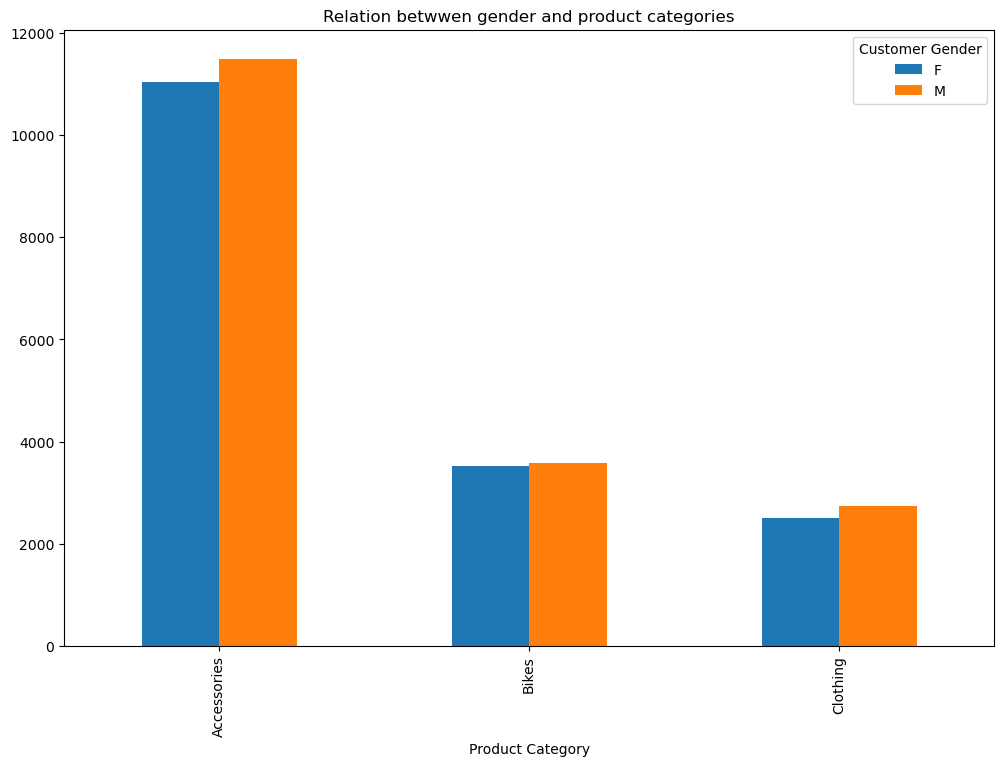

In [14]:
gender_category_df.plot(kind = 'bar', figsize=(12, 8))
plt.title('Relation betwwen gender and product categories')
plt.show()

From the table, we can see that for each product cetegory, the distribution was in a similar scale, with slightly more frequency for male's clothing transaction.

Although the numbers are quite similar, we still need to convert the corresponding chi2 statistic to our p-value of chi2 distribution, in this case, the degree of freedom (DOF) used will be the parameters in variable's number of categories:

$$
\begin{aligned}
DOF & = (\text{\# of product categories - 1}) \times (\text{\# of gender categories - 1})
\\
DOF & = 2
\end{aligned}
$$

We will be using scipy's chi2 test of independence for contigency tables. 

The hypothesis are as follows:

$$ H_0 = \text{The relation between variables are independent}$$
$$ H_1 = \text{The relation between batiables are not independent}$$

In [15]:
scipy.stats.chi2_contingency(gender_category_df)

(3.7174085431453174,
 0.15587447055732034,
 2,
 array([[11026.57528825, 11507.42471175],
        [ 3470.82180348,  3622.17819652],
        [ 2563.60290828,  2675.39709172]]))

From the above result, we can see that the p-value is 0.1558, which we failed to reject the null hypothesis that gender is independent of product bought.

## Conclusion

>> There is no statistical significant proof that gender is related to product bought.

In [16]:
def chi2_test(df, col1, col2, show_table = True):
    assert col1 in df.columns and col2 in df.columns, 'Column names provide can not be found in dataframe!'
    _cont = df.groupby([col1, col2])[col2].count().unstack()
    _result = scipy.stats.chi2_contingency(_cont)
    if show_table:
        print('------------------------------')
        print('Observed contigency table')
        display(_cont)
        print('------------------------------')
        print('Expected frequency table')
        display(pd.DataFrame(_result[-1], index = _cont.index, 
                    columns = _cont.columns))
    print(f'The p-value of chi2 independence test is {_result[1]:.4f}')

In [17]:
chi2_test(sales_df, 'Country', 'Product Category')

------------------------------
Observed contigency table


Product Category,Accessories,Bikes,Clothing
Country,,,
France,3293,1152,723
Germany,3200,1291,710
United Kingdom,3986,1497,938
United States,12055,3153,2868


------------------------------
Expected frequency table


Product Category,Accessories,Bikes,Clothing
Country,,,
France,3340.093845,1051.357311,776.548844
Germany,3361.421844,1058.070699,781.507457
United Kingdom,4149.911490,1306.262634,964.825876
United States,11682.572822,3677.309356,2716.117823


The p-value of chi2 independence test is 0.0000


>> From the above result, we can see that there was deviation in sales, especially between United States with other countries. Infact, the corresponding p-value is 0, indicating there is a relation between the distribution of product sold and countries.

# Clustering analysis

After we have established that there are no interesting relation between the variables, let's dive deep into clustering analysis.

The aim of this section is to analyize customers behaviours, and determine if there are any groups with different spending habits, corresponding to different demographics.

In [18]:
sales_df.head()

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,net_profit,Day,Month_numeric
index,,,,,,,,,,,,,,,,,
0,02/19/16,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,1.0,80.00,109.000000,80.0,109.0,29,19,2
1,02/20/16,2016,February,29,F,United States,Washington,Clothing,Gloves,2.0,24.50,28.500000,49.0,57.0,8,20,2
2,02/27/16,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,3.0,3.67,5.000000,11.0,15.0,4,27,2
3,03/12/16,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,2.0,87.50,116.500000,175.0,233.0,58,12,3
4,03/12/16,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,3.0,35.00,41.666667,105.0,125.0,20,12,3


Before we can continue to our analysis, we have to preprocess several things, notice that we have several categorical categories:

In [19]:
sales_df.select_dtypes('object').columns

Index(['Date', 'Month', 'Customer Gender', 'Country', 'State',
       'Product Category', 'Sub Category'],
      dtype='object')

We will be excluding the Date and Month columns, as the purpose is not a time series analysis, and the categorical columns will be one-hot encoded, in order to be feed in to a clustering algorithm.

In [20]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

From our previous analysis in Tableau, we have singled out that California state and England has some interesting behaviour, which their revenues increased significantly overtime.

For this reason, we will single out California state and treat it as a seperate entry in the Country column.

In [21]:
sales_df['Country_with_California'] = sales_df.apply(lambda x: x['Country'] if x['State'] != 'California' 
                                                        else 'California', axis = 1)

<AxesSubplot: >

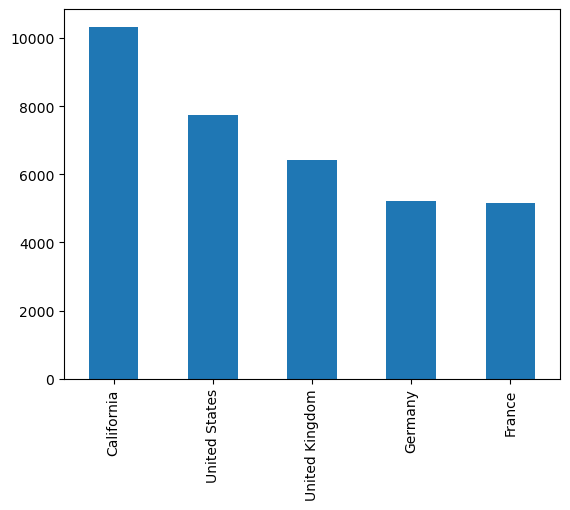

In [22]:
sales_df['Country_with_California'].value_counts().plot(kind='bar')

In [23]:
unwanted_col = ['Date', 'Year', 'Month', 'Quantity', 'Unit Cost', 'Unit Price', 'Day', 'Month_numeric', 
                    'Country', 'Sub Category', 'State']
remaining_col = [x for x in list(sales_df.columns) if x not in unwanted_col]
remaining_col

['Customer Age',
 'Customer Gender',
 'Product Category',
 'Cost',
 'Revenue',
 'net_profit',
 'Country_with_California']

In [24]:
clustering_df = sales_df[remaining_col]

In [25]:
clustering_df.head()

,Customer Age,Customer Gender,Product Category,Cost,Revenue,net_profit,Country_with_California
index,,,,,,,
0,29,F,Accessories,80.0,109.0,29,United States
1,29,F,Clothing,49.0,57.0,8,United States
2,29,F,Accessories,11.0,15.0,4,United States
3,29,F,Accessories,175.0,233.0,58,United States
4,29,F,Accessories,105.0,125.0,20,United States


In [26]:
ct = ColumnTransformer([('ohe', OneHotEncoder(), ['Customer Gender', 'Country_with_California', 
                            'Product Category'])], 
                        # ('mmscaler', MinMaxScaler(), make_column_selector(dtype_include=['number', 'object']))],
                       remainder='passthrough', 
                       verbose_feature_names_out=False) 

In [27]:
pipe = Pipeline([('ohe', ct), 
                ('mascaler', MaxAbsScaler())])
                # ('clustering', DBSCAN())])

In [28]:
clustering_transformed = pipe.fit_transform(clustering_df)

In [29]:
clustering_tf_df = pd.DataFrame(clustering_transformed, 
                                columns=pipe.get_feature_names_out())
clustering_tf_df

,Customer Gender_F,Customer Gender_M,Country_with_California_California,Country_with_California_France,Country_with_California_Germany,Country_with_California_United Kingdom,Country_with_California_United States,Product Category_Accessories,Product Category_Bikes,Product Category_Clothing,Customer Age,Cost,Revenue,net_profit
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.333333,0.022222,0.021448,0.015744
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.333333,0.013611,0.011216,0.004343
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.333333,0.003056,0.002952,0.002172
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.333333,0.048611,0.045848,0.031488
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.333333,0.029167,0.024597,0.010858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34861,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.436782,0.569167,0.292601,-0.305103
34862,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.436782,0.644444,0.387839,-0.189468
34863,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.436782,0.569167,0.311492,-0.252986
34864,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.436782,0.569167,0.330972,-0.199240


In [30]:
dbs = DBSCAN()

dbs_result = dbs.fit(clustering_tf_df)


To determine if the clustering is a good representation, we will be using the silhouette_score from sklearn.

The silhouette score is a metric defined to quantify how well the clustering is performing, by calculating the ratio between 

* The mean distance of points in the same cluster (intra-cluster distance)
* Distance from points to nearest other clusters.

It represents how confidence of the points being in a 'correct' cluster.

For more information, please refer to the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

<img src="https://miro.medium.com/max/875/1*YFpqMNrfi8pjaU28zpjs0g.png">

In [31]:
silhouette_score(clustering_tf_df, dbs_result.labels_)

0.8174959664660164

## K-prototype clustering

In the previous sub-section, we have explored the option of clustering the dataframe by one-hot-encoding. However, this method is not all sensible. The distance metric was arbitrary, although the Mahalanobis distance was used, there is no guarantee that the distance calculated is a good representation of the datapoints clustering (how is the distance between California and England comparable with the distance of $200 difference in revenue?).

Another method we will be using is the K-Prototypes clustering, which is a combination of K-means and K-modes algorithms.

In [32]:
from kmodes.kprototypes import KPrototypes

In [33]:
clustering_df.head()

,Customer Age,Customer Gender,Product Category,Cost,Revenue,net_profit,Country_with_California
index,,,,,,,
0,29,F,Accessories,80.0,109.0,29,United States
1,29,F,Clothing,49.0,57.0,8,United States
2,29,F,Accessories,11.0,15.0,4,United States
3,29,F,Accessories,175.0,233.0,58,United States
4,29,F,Accessories,105.0,125.0,20,United States


In [34]:
numeric_scaler = ColumnTransformer([('std_scaler', StandardScaler(), 
                        make_column_selector(dtype_include='number'))], 
                        remainder = 'passthrough', 
                        verbose_feature_names_out=False)

clustering_scaled_df = pd.DataFrame(numeric_scaler.fit_transform(clustering_df),  
                                    columns = numeric_scaler.get_feature_names_out()).apply(lambda x: pd.to_numeric(x, errors='ignore'))

clustering_scaled_df


,Customer Age,Cost,Revenue,net_profit,Customer Gender,Product Category,Country_with_California
0,-0.664363,-0.718337,-0.722022,-0.234603,F,Accessories,United States
1,-0.664363,-0.763232,-0.792612,-0.371968,F,Clothing,United States
2,-0.664363,-0.818265,-0.849628,-0.398132,F,Accessories,United States
3,-0.664363,-0.580753,-0.553690,-0.044909,F,Accessories,United States
4,-0.664363,-0.682130,-0.700301,-0.293473,F,Accessories,United States
...,...,...,...,...,...,...,...
34861,0.145518,2.133260,1.148634,-4.100438,M,Bikes,France
34862,0.145518,2.525734,1.805672,-2.707167,M,Bikes,France
34863,0.145518,2.133260,1.278956,-3.472485,M,Bikes,France
34864,0.145518,2.133260,1.413350,-2.824908,M,Bikes,France


In [35]:
clustering_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34866 entries, 0 to 34865
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer Age             34866 non-null  float64
 1   Cost                     34866 non-null  float64
 2   Revenue                  34866 non-null  float64
 3   net_profit               34866 non-null  float64
 4   Customer Gender          34866 non-null  object 
 5   Product Category         34866 non-null  object 
 6   Country_with_California  34866 non-null  object 
dtypes: float64(4), object(3)
memory usage: 1.9+ MB


In [36]:
cat_position = [clustering_scaled_df.columns.get_loc(col) for col in 
                    clustering_scaled_df.select_dtypes('object').columns]
cat_position

[4, 5, 6]

In [37]:

clustering_scaled_df.select_dtypes('object').columns

Index(['Customer Gender', 'Product Category', 'Country_with_California'], dtype='object')

In [38]:
kproto = KPrototypes()

kproto.fit_predict(clustering_scaled_df, categorical = cat_position )

array([2, 2, 2, ..., 1, 1, 1], dtype=uint16)

In [43]:
kproto.cost_

50598.26475831384

In [46]:
kproto_results ={'cluster_size': [], 'cost':[]} 

clustering_scaled_df_sample = clustering_scaled_df.sample(frac=0.5)

for cluster_size in range(1, 21):
    print(f'Fitting Kprototypes for cluster size :{cluster_size}')
    _kproto = KPrototypes(n_clusters=cluster_size)
    _labels = _kproto.fit_predict(clustering_scaled_df_sample, categorical = cat_position)
    kproto_results['cluster_size'].append(cluster_size)
    kproto_results['cost'].append(_kproto.cost_)
    print(f'Cost: {_kproto.cost_}')
    print('----------------------------------------')

Fitting Kprototypes for cluster size :1
Cost: 82751.07780185876
----------------------------------------
Fitting Kprototypes for cluster size :2
Cost: 54845.64949991649
----------------------------------------
Fitting Kprototypes for cluster size :3
Cost: 44318.23398783565
----------------------------------------
Fitting Kprototypes for cluster size :4
Cost: 35972.67031012088
----------------------------------------
Fitting Kprototypes for cluster size :5
Cost: 31245.550764049847
----------------------------------------
Fitting Kprototypes for cluster size :6
Cost: 28803.488442624857
----------------------------------------
Fitting Kprototypes for cluster size :7
Cost: 26901.456459983554
----------------------------------------
Fitting Kprototypes for cluster size :8
Cost: 25280.318499293295
----------------------------------------
Fitting Kprototypes for cluster size :9
Cost: 24016.359477884664
----------------------------------------
Fitting Kprototypes for cluster size :10
Cost: 227

KeyboardInterrupt: 

In [47]:
import pickle

with open('kproto_result.pkl', 'wb') as file:
    pickle.dump(kproto_results, file=file)



In [49]:
with open('./kproto_result.pkl', 'rb') as file:
    test = pickle.load(file)

In [50]:
test

{'cluster_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'cost': [82751.07780185876,
  54845.64949991649,
  44318.23398783565,
  35972.67031012088,
  31245.550764049847,
  28803.488442624857,
  26901.456459983554,
  25280.318499293295,
  24016.359477884664,
  22781.379174912316,
  21741.203708859262,
  21043.12467361774,
  20477.236389255944,
  19913.816817386854]}

# Hyperparameter tuning

Now that we have demonstrated on how to peform clustering by using DBSCAN, we will move on to tuning the hyperparameters, to obtain the clustering with best silhoutte score.

[optuna](https://optuna.readthedocs.io/en/stable/) is a hyperparameter framework, which optimizes python loops to exhaust the search space automatically. 

Alternative to Optuna, a function of manaul Python loops can be written, Sklearn GridSearchCV would be incompatible, since clustering algorithm (such as DBSCAN) lacks a `.transform()` method.

In [34]:
import optuna
from sklearn.neighbors import DistanceMetric

In [35]:
mahala = DistanceMetric.get_metric('mahalanobis', V=np.cov(clustering_tf_df.to_numpy().T))

/home/shiya/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


In [36]:
dbs_test = DBSCAN(metric=mahala)

In [37]:
np.cov(clustering_tf_df.to_numpy().T).shape

(14, 14)

In [38]:
# Defining variables needed to calculate Malahanobis distance
df_cov = np.cov(clustering_tf_df.to_numpy().T)
mahala = DistanceMetric.get_metric('mahalanobis', V=df_cov)
assert df_cov.shape == (clustering_tf_df.shape[1],
                        clustering_tf_df.shape[1])

def objective(trial):

    _epsilon = trial.suggest_float('_epsilon', 0.1, 2)
    _min_samples = trial.suggest_int('_min_samples', 5, 1000, log= True)
    _distance = trial.suggest_categorical('_distance', ['euclidean', 'manhattan', 'mahalanobis'])
    if _distance == 'mahalanobis':
        _dbs = DBSCAN(eps=_epsilon, min_samples=_min_samples, metric=_distance, metric_params={'V':df_cov})
    else:
        _dbs = DBSCAN(eps=_epsilon, min_samples=_min_samples, metric=_distance)
    _dbs.fit(clustering_tf_df)
    try:
        if _distance =='mahalanobis':
            return silhouette_score(clustering_tf_df, _dbs.labels_, metric=_distance, 
                                    # We will reduce the sample_size for calculating silhouette score,
                                    # as the calculation is computationally expensive.
                                    sample_size = int(clustering_tf_df.shape[0]*0.6), random_state = 42, 
                                    V=df_cov)
        else:
            return silhouette_score(clustering_tf_df, _dbs.labels_, metric=_distance, 
                                    # We will reduce the sample_size for calculating silhouette score,
                                    # as the calculation is computationally expensive.
                                    sample_size = int(clustering_tf_df.shape[0]*0.6), random_state = 42) 
    except:
        return 0

In [39]:
{1:2 if 1==2 else None}

{1: None}

In [40]:
study = optuna.create_study()
study.optimize(objective, n_trials = 20)

[I 2023-01-10 13:25:27,590] A new study created in memory with name: no-name-32ba69a7-e5f2-454d-8b90-ab59ec87b500
[I 2023-01-10 13:25:44,155] Trial 0 finished with value: 0.814946872975206 and parameters: {'_epsilon': 0.5027805351030847, '_min_samples': 186, '_distance': 'manhattan'}. Best is trial 0 with value: 0.814946872975206.
[I 2023-01-10 13:26:01,826] Trial 1 finished with value: 0.8177749586076231 and parameters: {'_epsilon': 0.9198643436595008, '_min_samples': 12, '_distance': 'euclidean'}. Best is trial 0 with value: 0.814946872975206.
[I 2023-01-10 13:26:41,980] Trial 2 finished with value: 0.0 and parameters: {'_epsilon': 1.9469856504268541, '_min_samples': 54, '_distance': 'euclidean'}. Best is trial 2 with value: 0.0.
[I 2023-01-10 13:27:02,287] Trial 3 finished with value: 0.8177749586076231 and parameters: {'_epsilon': 0.9101727438238539, '_min_samples': 8, '_distance': 'euclidean'}. Best is trial 2 with value: 0.0.
[I 2023-01-10 13:29:01,569] Trial 4 finished with valu

In [41]:
clustering_tf_df.shape

(34866, 14)

In [42]:
# dbs_dict = {'epsilon':[], 'min_sample':[], 'sil_score':[]}

# for ep in np.linspace(0.1, 4, 20):
#     for minsamp in np.logspace(5, 1000, 20):
#         for _distance in ['euclidean', 'manhattan']:
#             print(f'Fitting on epsion: {ep}, minimum_sample: {minsamp} with distance: {_distance}')
#             _dbs = DBSCAN(eps=ep, min_samples=minsamp, metric=_distance)
#             _dbs.fit(clustering_tf_df)
#             dbs_dict['epsilon'].append(ep)
#             dbs_dict['min_sample'].append(minsamp)
#             try:
#                 sil_score = silhouette_score(clustering_tf_df, _dbs.labels_, metric=_distance, 
#                                             sample_size = int(clustering_tf_df.shape[0]*0.6), random_state = 42)
#             except:
#                 sil_score = 0
#             dbs_dict['sil_score'].append(sil_socre)
#             print(dbs_dict)
